In [1]:
# Importing Necesaary Library
import scipy.io
import math
import numpy as np

import copy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

# Part 1

### Loading CT Scans

In [2]:
data = scipy.io.loadmat("/raid/home/ujjawald/CourseWork/AIMIA/Ass2/data/ctscan_embeddings_hw2.mat")
ct_scans = data['feat']
print(ct_scans.shape)

(3554, 1024)


### Dim. from 1024 to 100

In [3]:
# Reducing the dim
pca_100 = PCA(n_components=100)
ct_100 = pca_100.fit_transform(ct_scans)
print(ct_100.shape)

# Reconstructing the scans
reconstructed_ct_100 = pca_100.inverse_transform(ct_100)
print(reconstructed_ct_100.shape)

# Calculating the Reconstruction Error
error_100 = mean_squared_error(reconstructed_ct_100, ct_scans)
print(error_100)

(3554, 100)
(3554, 1024)
0.0012483434


### Dim. from 1024 to 50

In [4]:
# Reducing the dim
pca_50 = PCA(n_components=50)
ct_50 = pca_50.fit_transform(ct_scans)
print(ct_50.shape)

# Reconstructing the scans
reconstructed_ct_50 = pca_50.inverse_transform(ct_50)
print(reconstructed_ct_50.shape)


# Calculating the Reconstruction Error
error_50 = mean_squared_error(reconstructed_ct_50, ct_scans)
print(error_50)

(3554, 50)
(3554, 1024)
0.003040897


### Plot: Reconstruction Error vs #Principal Componenets

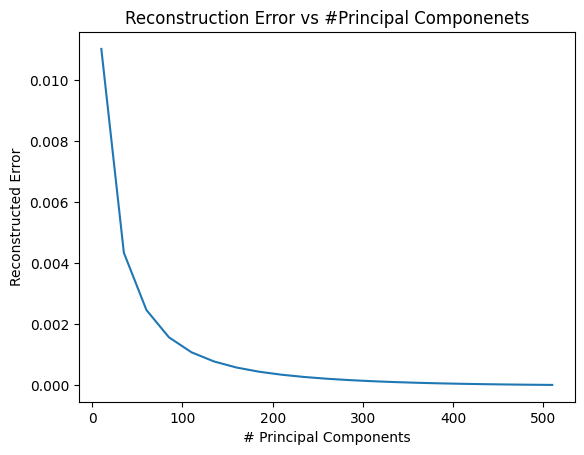

In [6]:
reconstruction_error_list = []
y = []
for i in range(10,511,25):
    # Reducing the dim
#     print(i)
    pca = PCA(n_components=i)
    ct = pca.fit_transform(ct_scans)

    # Reconstructing the scans
    reconstructed_ct = pca.inverse_transform(ct)

    # Calculating the Reconstruction Error
    reconstruction_error = mean_squared_error(reconstructed_ct, ct_scans)
    y.append(i)
    reconstruction_error_list.append(reconstruction_error)
    
plt.plot(y, reconstruction_error_list)
plt.xlabel("# Principal Components")
plt.ylabel("Reconstructed Error")
plt.title("Reconstruction Error vs #Principal Componenets")
plt.show()

# Part 2

In [7]:
# Reducing the dim. to 150 using PCA
pca_150 = PCA(n_components=150)
ct_150 = pca_150.fit_transform(ct_scans)
print(ct_150.shape)

(3554, 150)


### Loading labels from infection masks

In [8]:
def get_infection_rate(infmsk):
    count_infection = np.count_nonzero(infmsk == 1)
    count_healthy = np.count_nonzero(infmsk == 2)
    inf_rate = (count_infection/(count_infection+count_healthy)) * 100
    return inf_rate

def get_label(inf_rate):
    if(inf_rate == 0):
        return 0
    if(inf_rate<=40):
        return 1
    return 2

In [9]:
data_inf = scipy.io.loadmat("/raid/home/ujjawald/CourseWork/AIMIA/Ass2/data/infmsk_hw1.mat")
# print(data_inf)
infmask = data_inf['infmsk']
infection_masks = []
for i in range(infmask.shape[2]):
    infection_masks.append(infmask[:,:,i])
infection_masks = np.array(infection_masks)

y = []
for i in range(infection_masks.shape[0]):
    y.append(get_label(get_infection_rate(infection_masks[i])))
    
print(len(y))

3554


### Train, valid, test split

In [10]:
X_train, X_test_temp, y_train, y_test_temp = train_test_split(ct_150, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_temp, y_test_temp, test_size=0.6666667, random_state=42)

print(len(y_train))
print(len(y_val))
print(len(y_test))

2487
355
712


### Different helper functions for evaluation metrics

In [11]:
def get_confusion_metric(true_y, pred_y):
    true_y = true_y.flatten()
    pred_y = pred_y.flatten()
    return confusion_matrix(true_y, pred_y,labels=[0,1,2])
  
def get_acc_f1(tp,tn,fp,fn):
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*precision*recall)/(precision + recall)
    return accuracy*100, f1

def get_req_avg_eval_metrics(true_y, pred_y):
    
    confusion_metric = (get_confusion_metric(true_y,pred_y)).T
    
    normal_TP = confusion_metric[0][0]
    normal_TN = confusion_metric[1][1] + confusion_metric[1][2] + confusion_metric[2][1] + confusion_metric[2][2]
    normal_FP = confusion_metric[0][1] + confusion_metric[0][2] 
    normal_FN = confusion_metric[1][0] + confusion_metric[2][0]
  
    mild_TP = confusion_metric[1][1]
    mild_TN = confusion_metric[0][0] + confusion_metric[2][0] + confusion_metric[0][2] + confusion_metric[2][2]
    mild_FP = confusion_metric[1][0] + confusion_metric[1][2] 
    mild_FN = confusion_metric[0][1] + confusion_metric[2][1]

    severe_TP = confusion_metric[2][2]
    severe_TN = confusion_metric[0][0] + confusion_metric[0][1] + confusion_metric[1][0] + confusion_metric[1][1]
    severe_FP = confusion_metric[2][0] + confusion_metric[2][1] 
    severe_FN = confusion_metric[0][2] + confusion_metric[1][2]
    
    normal_acc, normal_f1 = get_acc_f1(normal_TP,normal_TN,normal_FP,normal_FN)
    mild_acc, mild_f1 = get_acc_f1(mild_TP,mild_TN,mild_FP,mild_FN)
    severe_acc, severe_f1 = get_acc_f1(severe_TP,severe_TN,severe_FP,severe_FN)
    
    return (normal_acc, normal_f1, mild_acc, mild_f1, severe_acc, severe_f1)

## SVM with Linear Kernel

In [12]:
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)

In [13]:
pred = linear.predict(X_train)
true = np.array(y_train)

normal_acc, normal_f1, mild_acc, mild_f1, severe_acc, severe_f1 = get_req_avg_eval_metrics(true, pred)

In [14]:
print("LINEAR KERNEL with Train Data")
print()
print("NORMAL")
print("Accuracy = ", "%.2f" % normal_acc)
print("F1 Score = ", "%.2f" % normal_f1)
print()
print("MILD")
print("Accuracy = ", "%.2f" % mild_acc)
print("F1 Score = ", "%.2f" % mild_f1)
print()
print("Severe")
print("Accuracy = ", "%.2f" % severe_acc)
print("F1 Score = ", "%.2f" % severe_f1)

LINEAR KERNEL with Train Data

NORMAL
Accuracy =  93.85
F1 Score =  0.92

MILD
Accuracy =  93.65
F1 Score =  0.94

Severe
Accuracy =  99.56
F1 Score =  0.95


In [15]:
pred = linear.predict(X_val)
true = np.array(y_val)

normal_acc, normal_f1, mild_acc, mild_f1, severe_acc, severe_f1 = get_req_avg_eval_metrics(true, pred)

In [16]:
print("LINEAR KERNEL with Validation Data")
print()
print("NORMAL")
print("Accuracy = ", "%.2f" % normal_acc)
print("F1 Score = ", "%.2f" % normal_f1)
print()
print("MILD")
print("Accuracy = ", "%.2f" % mild_acc)
print("F1 Score = ", "%.2f" % mild_f1)
print()
print("Severe")
print("Accuracy = ", "%.2f" % severe_acc)
print("F1 Score = ", "%.2f" % severe_f1)

LINEAR KERNEL with Validation Data

NORMAL
Accuracy =  93.52
F1 Score =  0.93

MILD
Accuracy =  93.80
F1 Score =  0.94

Severe
Accuracy =  99.15
F1 Score =  0.88


In [17]:
pred = linear.predict(X_test)
true = np.array(y_test)

normal_acc, normal_f1, mild_acc, mild_f1, severe_acc, severe_f1 = get_req_avg_eval_metrics(true, pred)

In [18]:
print("LINEAR KERNEL with Test Data")
print()
print("NORMAL")
print("Accuracy = ", "%.2f" % normal_acc)
print("F1 Score = ", "%.2f" % normal_f1)
print()
print("MILD")
print("Accuracy = ", "%.2f" % mild_acc)
print("F1 Score = ", "%.2f" % mild_f1)
print()
print("Severe")
print("Accuracy = ", "%.2f" % severe_acc)
print("F1 Score = ", "%.2f" % severe_f1)

LINEAR KERNEL with Test Data

NORMAL
Accuracy =  91.57
F1 Score =  0.90

MILD
Accuracy =  91.29
F1 Score =  0.92

Severe
Accuracy =  99.16
F1 Score =  0.89


## SVM with RBF Kernel

In [19]:
rbf = svm.SVC(kernel='rbf', gamma=0.08, C=1, decision_function_shape='ovo').fit(X_train, y_train)

In [20]:
pred = rbf.predict(X_train)
true = np.array(y_train)

normal_acc, normal_f1, mild_acc, mild_f1, severe_acc, severe_f1 = get_req_avg_eval_metrics(true, pred)

In [21]:
print("RBF KERNEL with Train Data")
print()
print("NORMAL")
print("Accuracy = ", "%.2f" % normal_acc)
print("F1 Score = ", "%.2f" % normal_f1)
print()
print("MILD")
print("Accuracy = ", "%.2f" % mild_acc)
print("F1 Score = ", "%.2f" % mild_f1)
print()
print("Severe")
print("Accuracy = ", "%.2f" % severe_acc)
print("F1 Score = ", "%.2f" % severe_f1)

RBF KERNEL with Train Data

NORMAL
Accuracy =  97.06
F1 Score =  0.96

MILD
Accuracy =  96.90
F1 Score =  0.97

Severe
Accuracy =  99.52
F1 Score =  0.95


In [22]:
pred = rbf.predict(X_val)
true = np.array(y_val)

normal_acc, normal_f1, mild_acc, mild_f1, severe_acc, severe_f1 = get_req_avg_eval_metrics(true, pred)

In [23]:
print("RBF KERNEL with Validation Data")
print()
print("NORMAL")
print("Accuracy = ", "%.2f" % normal_acc)
print("F1 Score = ", "%.2f" % normal_f1)
print()
print("MILD")
print("Accuracy = ", "%.2f" % mild_acc)
print("F1 Score = ", "%.2f" % mild_f1)
print()
print("Severe")
print("Accuracy = ", "%.2f" % severe_acc)
print("F1 Score = ", "%.2f" % severe_f1)

RBF KERNEL with Validation Data

NORMAL
Accuracy =  96.34
F1 Score =  0.96

MILD
Accuracy =  95.21
F1 Score =  0.95

Severe
Accuracy =  98.87
F1 Score =  0.82


In [24]:
pred = rbf.predict(X_test)
true = np.array(y_test)

normal_acc, normal_f1, mild_acc, mild_f1, severe_acc, severe_f1 = get_req_avg_eval_metrics(true, pred)

In [25]:
print("RBF KERNEL with Test Data")
print()
print("NORMAL")
print("Accuracy = ", "%.2f" % normal_acc)
print("F1 Score = ", "%.2f" % normal_f1)
print()
print("MILD")
print("Accuracy = ", "%.2f" % mild_acc)
print("F1 Score = ", "%.2f" % mild_f1)
print()
print("Severe")
print("Accuracy = ", "%.2f" % severe_acc)
print("F1 Score = ", "%.2f" % severe_f1)

RBF KERNEL with Test Data

NORMAL
Accuracy =  94.66
F1 Score =  0.94

MILD
Accuracy =  93.82
F1 Score =  0.94

Severe
Accuracy =  98.88
F1 Score =  0.85


# COMPLETED